## Thinkful Capstone Project Notebook

In [11]:
"""
Created on Fri Mar 11 19:28:06 2016

THINKFUL DATA SCIENCE
CAPSTONE PROJECT

Lending Club Good/Bad Loan Prediction
Draft V2 (Include all codes)

See Final Report @ https://github.com/blackgenie13/thinkful_ds_projects/blob/master/.ipynb_checkpoints/00_Capstone_Project_Notebook-checkpoint.ipynb

@author: Michael Lin_2
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action = "ignore", category = DeprecationWarning)
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = FutureWarning)

%matplotlib inline
##############################################################################################
##################                PART A: DATA ACQUISITION                 ###################
################## 'ZIP_2010-2.csv' contain 3rd party zip-code based data  ###################
##############################################################################################

## Desktop Directory
df1 = pd.read_csv('C:/Users/Michael Lin_2/Desktop/Thinkful/Data/lending-club-project/LoanStats3a_securev1.csv', skiprows=1)
df2 = pd.read_csv('C:/Users/Michael Lin_2/Desktop/Thinkful/Data/lending-club-project/LoanStats3b_securev1.csv', skiprows=1)
df3 = pd.read_csv('C:/Users/Michael Lin_2/Desktop/Thinkful/Data/lending-club-project/ZIP_2010-2.csv')

## Laptop Directory
# df1 = pd.read_csv('C:/Users/black/Desktop/lending-club-project/LoanStats3a_securev1.csv', skiprows=1)
# df2 = pd.read_csv('C:/Users/black/Desktop/lending-club-project/LoanStats3b_securev1.csv', skiprows=1)
# df3 = pd.read_csv('C:/Users/black/Desktop/lending-club-project/ZIP_2010-2.csv')

## Quick Analysis
# df1.info()                        # names of all columns
# df1['loan_status'][39784:39800]   # there's a gap/empty row within the data - need to eliminate it
# df1['loan_status'].unique()       # check out all unique column names

## Getting rid of rows with status = "does not meet the credit policy" - no longer valid now.
## This also resulted closing the gap previously mentioned at idx 39784:39800
df1 = df1[df1.loan_status.str.contains("Does not meet the credit policy.") == False]
df3 = df3.rename(columns={'Zip': 'zip_code'})

## Concatinate df1 (2007-2011 loan data) and df2 (2012-2013 loan data)
df12 = pd.concat([df1, df2])
df12.shape

## Here are some code that would turn strings of time into time variables - however, we decided to 
## exclude all time-based variables as predictors as they do not make sense for prediction purposes.
# df12['issue_d'] = df12[pd.to_datetime(df12['issue_d'])
# df12['issue_year'] = pd.DatetimeIndex(df12['issue_d']).year
# df12['issue_month'] = pd.DatetimeIndex(df12['issue_d']).month

## We originally wanted to analyze all loans, but decided to only predict 3-year loans
## So we no longer need to exclude December-2013 loans as they are very close to maturing.
# df2 = df2[df2.issue_d != 'Dec-2013']

C:\Users\Michael Lin_2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(227911, 78)

In [13]:
##############################################################################################
##################   PART B: DATA CLEANING, ANALYSIS, AND MORE CLEANING    ###################
##################                                                         ###################
##############################################################################################

#######################################  DATA CLEANING  ######################################

## Only extract useful predictors (for loan data 'df12' only)
predictors = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', \
              'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', \
              'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', \
              'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', \
              'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', \
              'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', \
              'total_rev_hi_lim']
df12 = df12[predictors].copy()

## Dropping 'title' as the columns holds too many different strings - they are messy and
## likely contributes no values as a predictors.  Also many spelling errors.
df12.drop('title', axis=1, inplace=True)

## Dropping 'application_type' because there is only one value, which is "INDIVIDUAL"
df12.drop('application_type', axis=1, inplace=True)

## Dropping 'earliest_cr_line' because it's a time-based predictors, it doesn't make sense 
## to use it as a predictor because, even if it was significant, it would not apply to 
## future borrowers.
df12.drop('earliest_cr_line', axis=1, inplace=True)

# Strip '%' from 'int_rate' and 'revol_util' and reformat them as float type.
df12.int_rate = pd.Series(df12.int_rate).str.replace('%', '').astype(float)
df12.revol_util = pd.Series(df12.revol_util).str.replace('%', '').astype(float)

## We looked at the first word of all 'emp_title' - and found that similar to 'title', the 
## free text field is too messy to contain any useful information as an effective predictor,
## To use this as a predictor would require way too much effort for the scope of this project.
df12.emp_title = df12.emp_title.str.lower()            # Convert all to lower cap
temp = df12['emp_title'].str[0:].str.split(' ', return_type='frame')  # Extract the first word
df12['emp_title'] = temp[0]                            # Overwrite the field with first word
df12.emp_title.value_counts()                          # Look at all the first word
df12.drop('emp_title', axis=1, inplace=True)             # Dropping 'emp_title' as predictor

In [14]:
## Cleaning up the 'emp_length' in exiting string format and convert it into numeric values
df12.emp_length.value_counts()                           # All 'emp_length' value counts
df12.replace('n/a', np.nan, inplace=True)                # Replace 'n/a' with NaN
df12.emp_length.fillna(value=0, inplace=True)            # Fill all NaN with zeros (0)
df12['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
                            # Extract the number in string and replace the cell w/ # only
df12['emp_length'] = df12['emp_length'].astype(int)      # Convert column to integer
df12.emp_length.value_counts()                           # Double-check value_counts

10    70074
1     32493
2     20537
3     18063
5     17551
4     14290
6     14147
7     12982
8     10435
0      8957
9      8382
Name: emp_length, dtype: int64

In [15]:
## Exclude all loans that are 60 months (retaining only 36-month loans), and then drop the
## field as a predictor.
df12 = df12[df12['term']==' 36 months']
df12.term.value_counts()
df12.drop('term', axis=1, inplace=True)

In [16]:
## The two 'fico_range_xxx" variables give primiarly the same range - either in range of 
## 4 or 5; therefore, we'll only need to retain one of the fico score along with the 
## range and will drop one of the two fico scores.  We chose to drop 'fico_range_low'.
df12['fico_range'] = df12['fico_range_high'] - df12['fico_range_low']
df12.fico_range.value_counts()
df12.drop('fico_range_low', axis=1, inplace=True)

In [17]:
## Merging the zip code median income dataset ('df3') with Lending Club's dataset ('df12')
## Note that 'df3' contain two other data sources: median income of each zip code and
## whether the zip code is urban or rural or a mixture of both.  Because Lending Club's
## dataset only displays the first 3 digits of the zip codes (i.e. 123xx), we pre-processed
## the zip-code data in Excel by merging all information in the same format as '123xx'.
df = pd.merge(df12, df3, on='zip_code')
df.zip_code.value_counts()

## Adding a few more calculated predictors here (they're self-explainatory)
df['Median_range'] = df['Max_Median'] - df['Min_Median']
df['Dif_median_from_zip'] = df['annual_inc'] - df['Avg_Median']
df['Dif_mean_from_zip'] = df['annual_inc'] - df['Est_Mean']
df['loan_over_income'] = df['loan_amnt']/df['annual_inc']
df['loan_over_median'] = df['loan_amnt']/df['Avg_Median']

In [18]:
## Categorized the target variable 'target' based on 'loan_status' from the dataset
## Good Loans (target=1) are 'Fully Paid', 'Current', and 'In Grace Period'
## Bad Loans (target=0) are 'Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Charged Off'
## And then drop the 'loan_status' varabiel
df.loan_status.value_counts()
df['target'] = np.nan
bad_loan = ["Late (16-30 days)", "Late (31-120 days)", "Default", "Charged Off"]
good_loan = ["Fully Paid", "Current", "In Grace Period"]
df.ix[df.loan_status.isin(bad_loan), 'target'] = 0
df.ix[df.loan_status.isin(good_loan), 'target'] = 1
df.groupby(['loan_status', 'target']).loan_status.count().groupby(level=['loan_status','target']).value_counts()
df.drop('loan_status', axis=1, inplace=True)

In [19]:
## IMPUTATION - taking care of the NaN values
## Overalled, we decided to use median() to fill all the NaN values with the exceptions of
## 'mths_since_last_delinq' and 'mths_since_last_record' - for these two, we think it's more
## appropriate to use zeros (0).  As a result the only remaining predictor with NaN that
## would be imputated with median() is 'revol_util'.
imputed_features = df.median()
imputed_features[['mths_since_last_delinq','mths_since_last_record']] = 0
df = df.fillna(imputed_features)

df.isnull().sum()              # Check to see if any NaN value remains

loan_amnt                 0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
pymnt_plan                0
purpose                   0
zip_code                  0
addr_state                0
dti                       0
delinq_2yrs               0
fico_range_high           0
inq_last_6mths            0
mths_since_last_delinq    0
mths_since_last_record    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
initial_list_status       0
total_rev_hi_lim          0
fico_range                0
Avg_Median                0
Min_Median                0
Max_Median                0
Est_Mean                  0
Pop                       0
Est_tot_income            0
Est_household             0
Dif_mean_median           0
RU_Cat              

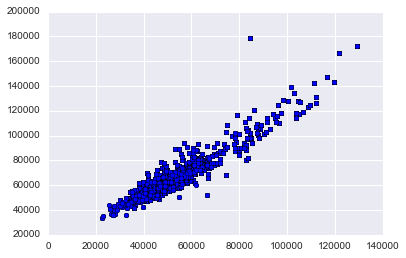

In [20]:
#############################  DATA ANALYSIS & MORE DATA CLEANING ############################

##'Est_tot_income' and 'Est_household' were created to estimate the mean income of each zip code 
## based on 'Pop' and 'income' so they are 100% correlated with exiting variable such as 'Pop'. 
## Here we drop both 'Est_tot_income' and 'Est_household' but retain 'Pop' (population).
df.drop('Est_tot_income', axis=1, inplace=True)
df.drop('Est_household', axis=1, inplace=True)

## It would seem that 'Avg_Median' and 'Est_Mean' are highly correlated at 0.951.
## As a result, we decided to drop 'Est_Mean'
plt.scatter(df.Avg_Median, df.Est_Mean)
plt.show()
np.corrcoef(df.Avg_Median, df.Est_Mean)
df.drop('Est_Mean', axis=1, inplace=True)

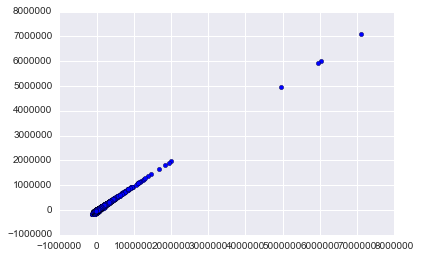

In [21]:
## It would seem that 'Dif_median_from_zip' and 'Dif_mean_from_zip' are highly correlated at 0.994.
## As a result, we decided to drop 'Dif_mean_from_zip'
plt.scatter(df.Dif_median_from_zip, df.Dif_mean_from_zip)
plt.show()
np.corrcoef(df.Dif_median_from_zip, df.Dif_mean_from_zip)
df.drop('Dif_mean_from_zip', axis=1, inplace=True)

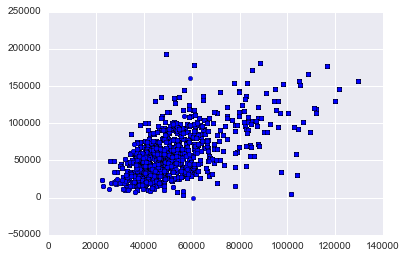

array([[ 1.        ,  0.58372763],
       [ 0.58372763,  1.        ]])

In [22]:
## 'Avg_Median' and 'Median_range" don't seem to be strongly correlated (at 0.584)
plt.scatter(df.Avg_Median, df.Median_range)
plt.show()
np.corrcoef(df.Avg_Median, df.Median_range)

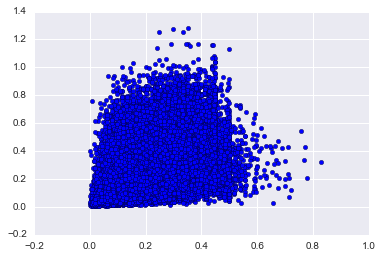

array([[ 1.        ,  0.54913363],
       [ 0.54913363,  1.        ]])

In [25]:
## 'loan_over_income' and 'loan_over_median' don't seem to be strongly correlated (at 0.549)
plt.scatter(df.loan_over_income, df.loan_over_median)
plt.show()
np.corrcoef(df.loan_over_income, df.loan_over_median)

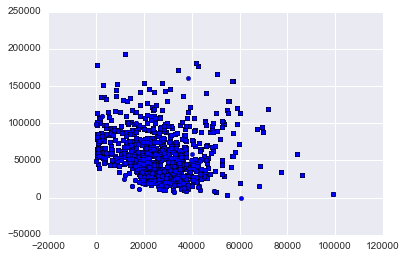

array([[ 1.        , -0.07749156],
       [-0.07749156,  1.        ]])

In [27]:
## 'Min_Median' and 'Median_range' don't seem to be correlated at all (at -0.077)
plt.scatter(df.Min_Median, df.Median_range)
plt.show()
np.corrcoef(df.Min_Median, df.Median_range)

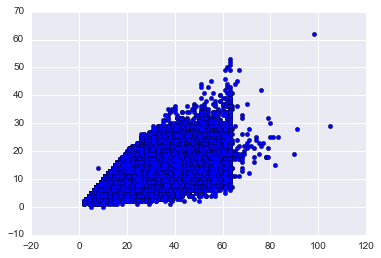

array([[ 1.        ,  0.67342544],
       [ 0.67342544,  1.        ]])

In [28]:
## 'total_acc" and "open_acc" seem to have some correlation at 0.673, we'll retain both as 
## predictors for now.
plt.scatter(df.total_acc, df.open_acc)
plt.show()
np.corrcoef(df.total_acc, df.open_acc)

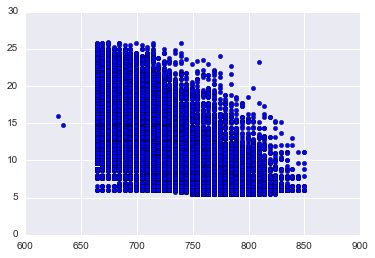

array([[ 1.        , -0.66953152],
       [-0.66953152,  1.        ]])

In [29]:
## 'fico_range_high' and 'int_rate' seem to be somewhat negatively correlated at -0.670, we'll 
## retain both as predictors for now.
plt.scatter(df.fico_range_high, df.int_rate)
plt.show()
np.corrcoef(df.fico_range_high, df.int_rate)

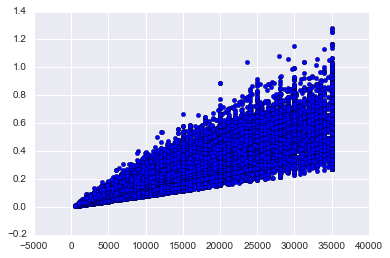

array([[ 1.      ,  0.883416],
       [ 0.883416,  1.      ]])

In [30]:
## 'loan_amnt" and "loan_over_median" seem to have somewhat strong correlation at 0.883, we'll 
## retain both as predictors for now.
plt.scatter(df.loan_amnt, df.loan_over_median)
plt.show()
np.corrcoef(df.loan_amnt, df.loan_over_median)

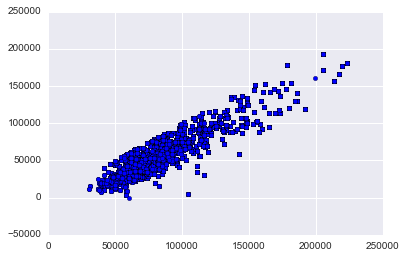

In [31]:
## 'Max_Median' and 'Median_range' seem to be highly correlated at 0.930.
## As a result, we decided to drop "Max_Median" and retain "Median_range"
plt.scatter(df.Max_Median, df.Median_range)
plt.show()
np.corrcoef(df.Max_Median, df.Median_range)
df.drop('Max_Median', axis=1, inplace=True)

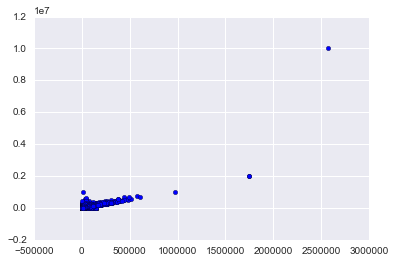

In [32]:
## Note: there may be some potential outliers in the variable 'total_rev_hi_lim'.  
## In addition, the varaible isn't complete and it seems to be strongly correlated with 
## 'revol_bal' at 0.7285; therefore, we'll drop 'total_rev_hi_lim' as well.
plt.scatter(df.revol_bal, df.total_rev_hi_lim)
plt.show()
np.corrcoef(df.revol_bal, df.total_rev_hi_lim)
df.drop('total_rev_hi_lim', axis=1, inplace=True)

In [33]:
## Next we identified 4 EXTREME outliers in the predictor 'revol_bal' that is over 
## 0.9-million.  We decided re-assign these four points with values that is the fifth
## highest in the column - 605,627 (at index 155881) so avoid extreme outliers problems.
# plt.hist(df['revol_bal'])
# plt.show()
# plt.boxplot(df['revol_bal'])
# plt.show()
df['revol_bal'].order(ascending=0).head(10)
top_r_bal = df['revol_bal'][155881]
df['revol_bal'][132714] = top_r_bal
df['revol_bal'][50689] = top_r_bal
df['revol_bal'][51162] = top_r_bal
df['revol_bal'][72921] = top_r_bal
df['revol_bal'].order(ascending=0).head(10)

C:\Users\Michael Lin_2\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Michael Lin_2\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Michael Lin_2\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Michael Lin_2\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be s

51162     605627
72921     605627
50689     605627
155881    605627
132714    605627
42144     570842
93265     509875
125395    491712
64244     488421
66255     481912
Name: revol_bal, dtype: float64

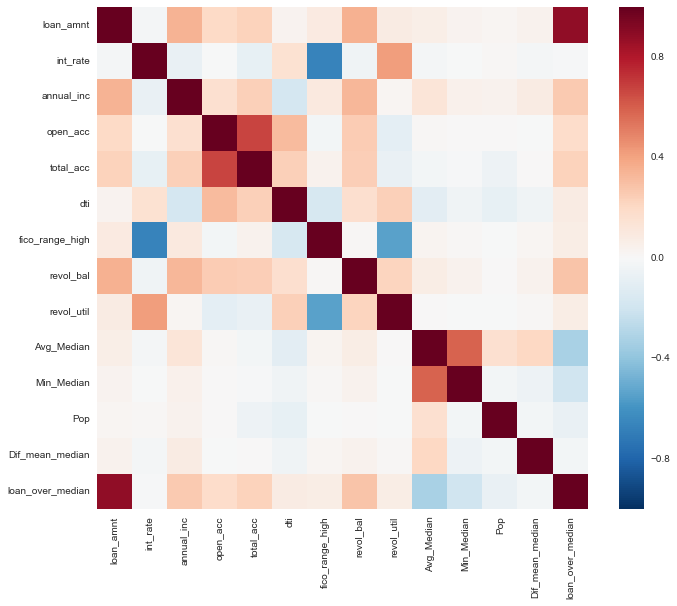

In [34]:
## Scatter Plot using Heat Map to show correlation of the remaining predictors
## In the interest of space, NOT all predictors are shown here.
sns.set(style="white")
corr = df[['loan_amnt','int_rate','sub_grade','annual_inc','open_acc','total_acc',\
           'dti','fico_range_high','revol_bal','revol_util','Avg_Median','Min_Median',\
           'Pop','Dif_mean_median','loan_over_median']].corr()  # Compute the correlation matrix
mask = np.zeros_like(corr, dtype=np.bool)               # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))                     # Set up the matplotlib figure
cmap = sns.diverging_palette(220, 10, as_cmap=True)       # Generate a custom diverging colormap
sns.heatmap(corr)                      # Draw the heatmap with the mask and correct aspect ratio
plt.show()

In [35]:
##############################################################################################
##################     PART C: ESTABLISH PERFORMANCE METRIC BASELINE       ###################
##################     Calculate Existing Good/Bad Loan Ratio and ROI      ###################
##############################################################################################

## Establish the overall accruacy of good loan (target=1)
accuracy_all = df['target'].mean()
print('The Overall Accuracy of Good Loans is: {:3.4f}%'.format(accuracy_all*100))

The Overall Accuracy of Good Loans is: 88.1547%


In [36]:
## Establish the good loan accuracy broken out by "Grade" assigned by Lending Club
grade_stats = pd.DataFrame(index=(['A','B','C','D','E','F','G']))
grade_stats['accuracy'] = pd.DataFrame(df.groupby(['grade']).target.mean())
# accuracy_grade.ix['A']               # Use this to select by index (e.g. Grade)
print('The Accuracy of Good Loans for each grade is (in percentage %):\n',grade_stats['accuracy']*100)


The Accuracy of Good Loans for each grade is (in percentage %):
 A    94.672328
B    89.941114
C    84.960933
D    80.559330
E    78.445808
F    75.895765
G    68.421053
Name: accuracy, dtype: float64


In [39]:
## Establish the (average) ROI of the overall loan pool (All)
## ROI is defined as (the interest of the loan) for good loan and zeros for bad laons
df['roi'] = df.int_rate * df.target
roi_all = df['roi'].mean()
print('The Overall Annualized ROI of All Loans is: {:3.4f}%'.format(roi_all))
## Double check result (successed!)
(df['target']==0).count()   # Out[]: 172879
(df['roi']==0).count()      # Out[]: 172879

The Overall Annualized ROI of All Loans is: 11.0742%


172879

In [40]:
## Establish the ROI of the loans broken out by "Grade" assigned by Lending Club
grade_stats['roi'] = df.groupby(['grade']).roi.mean()
print('The Annualized ROI of Loans for each grade is (in percentage %):\n',grade_stats['roi']*100)

The Annualized ROI of Loans for each grade is (in percentage %):
 A     715.796854
B    1056.870631
C    1279.320427
D    1457.961557
E    1617.105521
F    1716.230185
G    1537.631579
Name: roi, dtype: float64


In [41]:
## Establish the Average int rate (regardless good/bad loans) for each grade
grade_stats['int_rate'] = df.groupby(['grade'])['int_rate'].mean()

## Establish the difference between ROI and Average int rate (regardless good/bad loans) for each grade
grade_stats['roi_dif'] = df.groupby(['grade'])['roi'].mean() - df.groupby(['grade'])['int_rate'].mean()

## Record the number of data points for each grade group
grade_stats['count'] = pd.DataFrame(df.groupby(['grade']).target.count())

## Summerizing
print('Performance Metrics broken out by Grades: \n', grade_stats)

Performance Metrics broken out by Grades: 
    accuracy        roi   int_rate   roi_dif  count
A  0.946723   7.157969   7.575207 -0.417239  37446
B  0.899411  10.568706  11.772301 -1.203595  66399
C  0.849609  12.793204  15.075151 -2.281947  40315
D  0.805593  14.579616  18.105357 -3.525741  22813
E  0.784458  16.171055  20.633552 -4.462497   4890
F  0.758958  17.162302  22.585244 -5.422942    921
G  0.684211  15.376316  22.266632 -6.890316     95


In [42]:
#--------------------------------------------------------------------------------------------#
##################                  CONCLUDING NOTES:                      ###################
##################     Overall accuracy is 88.15%; we're dealing with      ###################
##################     very "unbalanced" dataset, and this is an acc-      ###################
##################     uracy tough to beat.  Therefore, we will need       ###################
##################     to balance the data first. And even with bala-      ###################
##################     nced data, we will likely not be able to beat       ###################
##################     the overall ROI at 11.07%.  Therefore, we will      ###################
##################     need to look into improving accuracy and ROI        ###################
##################     within the Grade subgroups instead as Grade A       ###################
##################     and Grade B have very good accuracy already.        ###################
#--------------------------------------------------------------------------------------------#

In [45]:
##############################################################################################
##################          PART F: LOGISTIC REGRESSION (NUMERIC)          ###################
##################    This model only tested on the numeric predictors     ###################
##############################################################################################
from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
                               NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids, OverSampler,\
                               SMOTE, SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
import itertools 
from scipy.stats.stats import pearsonr
from sklearn.metrics import confusion_matrix

In [47]:
##########################  COEFFICIENT SIGNIFICANT IDENTIFICATION  ##########################

## We first checked the coefficients here and determined the significant predictors based on p-values
## NOTE that the statsmodels.api is not as robust as we added more predictors - so we has to limit the
## number of predictors going into the first logistic model.  We excluded "annual_inc" and "fico_range",
## which we went back to test those two and they turned out to be insignificant against other predictors.
num_predictors_test = ['loan_amnt', 'int_rate', 'installment', 'dti', 'fico_range_high', \
                       'Avg_Median', 'Pop', 'delinq_2yrs', 'pub_rec', 'revol_bal', \
                       'emp_length', 'Median_range', 'loan_over_median', 'inq_last_6mths', \
                       'mths_since_last_delinq', 'mths_since_last_record', 'loan_over_income', \
                       'open_acc', 'revol_util', 'total_acc','Dif_median_from_zip', \
                       'RU_Ratio', 'Dif_mean_median', 'Min_Median']
                      
df_num_test = df[num_predictors_test].copy()
df_num_test['Intercept'] = 1.0

## Balancing the dataset so that good loans vs bad loans are more balanced
X_num = df_num_test.values
y = df.target.values

t_ratio =  np.count_nonzero(y==1) / np.count_nonzero(y==0) - 2
verbose = False
OS = OverSampler(ratio=t_ratio, verbose=verbose)
os_X_num, os_y = OS.fit_transform(X_num, y)

## Run the logistic regression on the entire dataset and look up the significance of coefficients
logit = sm.Logit(df['target'], df_num_test)
result = logit.fit()
print (result.summary())

Optimization terminated successfully.
         Current function value: 0.346615
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               172879
Model:                          Logit   Df Residuals:                   172854
Method:                           MLE   Df Model:                           24
Date:                Sun, 13 Mar 2016   Pseudo R-squ.:                 0.04732
Time:                        19:42:02   Log-Likelihood:                -59923.
converged:                       True   LL-Null:                       -62899.
                                        LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
loan_amnt                  0.0001   1.71e-05      7.457      0.000      9.42e-05    

In [48]:
#--------------------------------------------------------------------------------------------#
##################                  CONCLUDING NOTES:                      ###################
##################     By setting alph equal to 0.05, we can conclude      ###################
##################     that 'pop', 'Median_range', and 'mths_since_la      ###################
##################     st_record' can be eliminated as predictirs gi-      ###################
##################     ven their coefficient p-values are all greater      ###################
##################     than 0.05 at " will likely not be able to beat      ###################
##################     the overall ROI at 0.704, 0.982, and 0.668 re-      ###################
##################     spectively.                                         ###################
#--------------------------------------------------------------------------------------------#

In [49]:
##########################    LOGISTIC REGRESSION MODEL FUNCTION    ##########################

## Logistic Regression Function with Performance Outputs
def logistic_regression (X_train, X_test, y_train, y_test, zero_weight=1):
    """Perform logistic regression using Sklearn package
    Note, must already import LogisticRegression from sklearn.linear_model package
    Arguments:
    X_train -- The predictor-only array dataset for training the model
    X_test  -- The predictor-only array dataset for testing the trained model
    y_train -- The response-only array for training the model
    y_test  -- The response-only array for testing the model results
    zero_weight -- The weight to used for regression's class_weight parameter
                   for favoring predicint y=0; use positive integer only
                   Default value is 1 (i.e. no weight)
    """
    ## Fit the logistic regression model with class_wieght 1X-10X on y=0 (favoring y=0)    
    lr = LogisticRegression(class_weight={0: zero_weight})
    lr.fit(X_train, y_train)
    ## Predict test set target values using weighted model and compared accuracy
    y_predicted = lr.predict(X_test)
    confusion = pd.crosstab(y_test, y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)
    a, b = confusion.shape
    a -= 1
    print(confusion)
    print('The MODELED accuracy score of the test/valdiation set is {:2.3}%'.format(accuracy_score(y_test, y_predicted)*100))
    print('The MODELED accuracy on predicted good loans of test/valid. set is {:2.3f}% with {:2.3f}% reduced coverage'.format(confusion[1][a-1]/confusion[1][a]*100, (1-confusion[1][a]/confusion['All'][a])*100))
    print('The ACTUAL accuracy score of the test/validation set is {:2.3}%'.format(np.count_nonzero(y_test==1)/len(y_test)*100))
    roi_num_test_pred = X_test[:,1] * y_predicted * y_test
    print('The PREDICTED Annualized ROI of test/validation set on predicted good loans is: {:2.3f}%'.format(roi_num_test_pred.mean()))
    roi_num_test = X_test[:,1] * y_test
    print('The ACTUAL Annualized ROI of test/validation set on overall true good loans is: {:2.3f}%'.format(roi_num_test.mean()))
    print('\n')    
    return (y_predicted)

In [50]:
##########################     MODEL 1 - USING BALANCED DATASETS    ##########################

## Based on the conclusion, we select the following numeric coffcients:
num_predictors = ['loan_amnt', 'int_rate', 'installment', 'dti', 'fico_range_high', \
                  'Avg_Median', 'delinq_2yrs', 'pub_rec', 'revol_bal', 'emp_length', \
                  'loan_over_median', 'inq_last_6mths', 'mths_since_last_delinq', \
                  'loan_over_income', 'open_acc', 'revol_util', 'total_acc',\
                  'Dif_median_from_zip', 'RU_Ratio', 'Dif_mean_median', 'Min_Median']

df_num = df[num_predictors].copy()
df_num['Intercept'] = 1.0

## Making predictors array and response array
X_num = df_num.values
y = df.target.values

## Split the Original/Unbalanced Data using train_test_split function:
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size = 0.30, random_state=2016)
X_num.shape
y.shape

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_train==1) / np.count_nonzero(y_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
os_X_num_train, os_y_train = OS.fit_transform(X_num_train, y_train)
os_X_num_test, os_y_test = OS.fit_transform(X_num_test, y_test)

In [51]:
## Call the regression function on the Balanced Datasets (both training and test)
y_pre = logistic_regression (os_X_num_train, os_X_num_test, os_y_train, os_y_test)

Predicted    0.0    1.0    All
True                          
0.0        19813  18702  38515
1.0        14067  31760  45827
All        33880  50462  84342
The MODELED accuracy score of the test/valdiation set is 61.1%
The MODELED accuracy on predicted good loans of test/valid. set is 62.938% with 40.170% reduced coverage
The ACTUAL accuracy score of the test/validation set is 54.3%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 4.048%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 6.833%




In [52]:
## Call the regression function using balanced training set and tested on unbalanced (original) set
y_pre = logistic_regression (os_X_num_train, X_num_test, os_y_train, y_test)

Predicted    0.0    1.0    All
True                          
0.0         3132   2905   6037
1.0        14067  31760  45827
All        17199  34665  51864
The MODELED accuracy score of the test/valdiation set is 67.3%
The MODELED accuracy on predicted good loans of test/valid. set is 91.620% with 33.162% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.4%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 6.583%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.111%




In [53]:
#--------------------------------------------------------------------------------------------#
##################                  CONCLUDING NOTES:                      ###################
##################     When using balanced data sets, while we were        ###################
##################     able to improve the model accuracy of balance-      ###################
##################     d test sets, we weren't able to imporve either      ###################
##################     the accuracy or the ROI of the original/balan-      ###################
##################     ced test sets using the resulted model. We de-      ###################
##################     cided to try another model w/out balancing.         ###################
#--------------------------------------------------------------------------------------------#

In [55]:
##########################  MODEL 2 - USING CLASS_WEIGHT PARAMETERS ##########################
df_num = df[num_predictors].copy()
df_num['Intercept'] = 1.0
X_num = df_num.values
y = df.target.values

In [56]:
## Set the class_weight parameter at 3 to favor more on predicting y=0
zero_weight = 3
y_pre = logistic_regression (X_num_train, X_num_test, y_train, y_test, zero_weight)

Predicted   0.0    1.0    All
True                         
0.0         431   5606   6037
1.0        1372  44455  45827
All        1803  50061  51864
The MODELED accuracy score of the test/valdiation set is 86.5%
The MODELED accuracy on predicted good loans of test/valid. set is 88.802% with 3.476% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.4%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 10.566%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.111%




In [57]:
## Verifying result using Cross Validation on the entire Data Set: n_fold=5
skf = StratifiedKFold(y, n_folds=5, random_state=2016)

true_cv = []
pred_cv = []
accu_cv = []
for train_index, test_index in skf:
    y_pred = logistic_regression (X_num[train_index], X_num[test_index], y[train_index], y[test_index], zero_weight)
    true_cv.append(y[test_index])
    pred_cv.append(y_pred)
    accu_cv.append(accuracy_score(y[test_index], y_pred))

Predicted  0.0    1.0    All
True                        
0.0        206   3890   4096
1.0        570  29911  30481
All        776  33801  34577
The MODELED accuracy score of the test/valdiation set is 87.1%
The MODELED accuracy on predicted good loans of test/valid. set is 88.491% with 2.244% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 10.736%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.083%


Predicted  0.0    1.0    All
True                        
0.0        138   3958   4096
1.0        386  30094  30480
All        524  34052  34576
The MODELED accuracy score of the test/valdiation set is 87.4%
The MODELED accuracy on predicted good loans of test/valid. set is 88.377% with 1.516% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loan

Correlation between the actual and prediction is: 0.0642979651239 with p-value 0.00


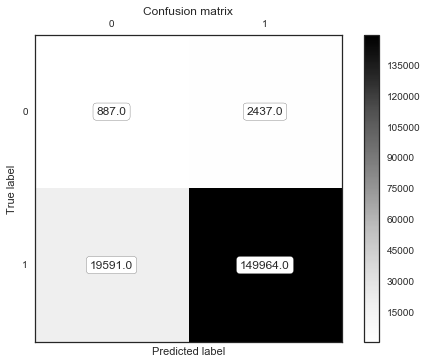

In [58]:
## Here we plot out the confusion matrix of the Cross-Validation Results
## However, note that the importance of the result is the Overall Increased ROI printed above.    
TrueLabel = list(itertools.chain(*true_cv))
PredictedLabel = list(itertools.chain(*pred_cv))
print ('Correlation between the actual and prediction is:', pearsonr(TrueLabel, PredictedLabel)[0], \
       'with p-value',  ("%2.2f" % pearsonr(TrueLabel, PredictedLabel)[1]))

cm = confusion_matrix(PredictedLabel, TrueLabel)
fig, ax = plt.subplots()
im = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

plt.title('Confusion matrix')
fig.colorbar(im)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [59]:
#--------------------------------------------------------------------------------------------#
##################                  CONCLUDING NOTES:                      ###################
##################     Using the numeric predictors selected by the        ###################
##################     balanced dataset, we were able to build a log-      ###################
##################     istic model based on original (unbalanced) da-      ###################
##################     taset using 'class_weight' to favor y=0 in or-      ###################
##################     der to produce results with bettero good laon       ###################
##################     predictions but with lower average ROI.             ###################
#--------------------------------------------------------------------------------------------#

In [60]:
########################## MODEL 3 - PREDICTING ON SUB-GROUP GRADES ##########################

##########################         MODEL 3a - GRADE A LOANS         ##########################
df_A = df[df['grade'] == 'A'].copy()
df_A.drop('grade', axis=1, inplace=True)
dfA_num = df_A[num_predictors].copy()
dfA_num['Intercept'] = 1.0
X_A_num = dfA_num.values
y_A = df_A.target.values

X_A_num_train, X_A_num_test, y_A_train, y_A_test = train_test_split(X_A_num, y_A, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_A_train==1) / np.count_nonzero(y_A_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_A_num_train, osy_A_train = OS.fit_transform(X_A_num_train, y_A_train)
osX_A_num_test, osy_A_test = OS.fit_transform(X_A_num_test, y_A_test)

In [62]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_A_num_train, osX_A_num_test, osy_A_train, osy_A_test)

Predicted   0.0    1.0    All
True                         
0.0        5318   4484   9802
1.0        4312   6333  10645
All        9630  10817  20447
The MODELED accuracy score of the test/valdiation set is 57.0%
The MODELED accuracy on predicted good loans of test/valid. set is 58.547% with 47.097% reduced coverage
The ACTUAL accuracy score of the test/validation set is 52.1%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 2.285%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 3.935%




In [63]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_A_num_train, X_A_num_test, osy_A_train, y_A_test)

Predicted   0.0   1.0    All
True                        
0.0         324   265    589
1.0        4312  6333  10645
All        4636  6598  11234
The MODELED accuracy score of the test/valdiation set is 59.3%
The MODELED accuracy on predicted good loans of test/valid. set is 95.984% with 41.268% reduced coverage
The ACTUAL accuracy score of the test/validation set is 94.8%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 4.159%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 7.162%




In [64]:
##########################         MODEL 3b - GRADE B LOANS         ##########################
df_B = df[df['grade'] == 'B'].copy()
df_B.drop('grade', axis=1, inplace=True)
dfB_num = df_B[num_predictors].copy()
dfB_num['Intercept'] = 1.0
X_B_num = dfB_num.values
y_B = df_B.target.values

X_B_num_train, X_B_num_test, y_B_train, y_B_test = train_test_split(X_B_num, y_B, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_B_train==1) / np.count_nonzero(y_B_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_B_num_train, osy_B_train = OS.fit_transform(X_B_num_train, y_B_train)
osX_B_num_test, osy_B_test = OS.fit_transform(X_B_num_test, y_B_test)

In [65]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_B_num_train, osX_B_num_test, osy_B_train, osy_B_test)

Predicted    0.0    1.0    All
True                          
0.0         6238   9350  15588
1.0         5268  12675  17943
All        11506  22025  33531
The MODELED accuracy score of the test/valdiation set is 56.4%
The MODELED accuracy on predicted good loans of test/valid. set is 57.548% with 34.315% reduced coverage
The ACTUAL accuracy score of the test/validation set is 53.5%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 4.321%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 6.292%




In [66]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_B_num_train, X_B_num_test, osy_B_train, y_B_test)

Predicted   0.0    1.0    All
True                         
0.0         802   1175   1977
1.0        5268  12675  17943
All        6070  13850  19920
The MODELED accuracy score of the test/valdiation set is 67.7%
The MODELED accuracy on predicted good loans of test/valid. set is 91.516% with 30.472% reduced coverage
The ACTUAL accuracy score of the test/validation set is 90.1%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 7.273%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 10.592%




In [67]:
##########################         MODEL 3c - GRADE C LOANS         ##########################
df_C = df[df['grade'] == 'C'].copy()
df_C.drop('grade', axis=1, inplace=True)
dfC_num = df_C[num_predictors].copy()
dfC_num['Intercept'] = 1.0
X_C_num = dfC_num.values
y_C = df_C.target.values

X_C_num_train, X_C_num_test, y_C_train, y_C_test = train_test_split(X_C_num, y_C, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_C_train==1) / np.count_nonzero(y_C_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_C_num_train, osy_C_train = OS.fit_transform(X_C_num_train, y_C_train)
osX_C_num_test, osy_C_test = OS.fit_transform(X_C_num_test, y_C_test)

In [68]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_C_num_train, osX_C_num_test, osy_C_train, osy_C_test)

Predicted   0.0    1.0    All
True                         
0.0        2135   6488   8623
1.0        1901   8353  10254
All        4036  14841  18877
The MODELED accuracy score of the test/valdiation set is 55.6%
The MODELED accuracy on predicted good loans of test/valid. set is 56.283% with 21.381% reduced coverage
The ACTUAL accuracy score of the test/validation set is 54.3%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 6.632%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 8.169%




In [69]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_C_num_train, X_C_num_test, osy_C_train, y_C_test)

Predicted   0.0   1.0    All
True                        
0.0         451  1390   1841
1.0        1901  8353  10254
All        2352  9743  12095
The MODELED accuracy score of the test/valdiation set is 72.8%
The MODELED accuracy on predicted good loans of test/valid. set is 85.733% with 19.446% reduced coverage
The ACTUAL accuracy score of the test/validation set is 84.8%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 10.350%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 12.749%




In [70]:
##########################         MODEL 3d - GRADE D LOANS         ##########################
df_D = df[df['grade'] == 'D'].copy()
df_D.drop('grade', axis=1, inplace=True)
dfD_num = df_D[num_predictors].copy()
dfD_num['Intercept'] = 1.0
X_D_num = dfD_num.values
y_D = df_D.target.values
X_D_num_train, X_D_num_test, y_D_train, y_D_test = train_test_split(X_D_num, y_D, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_D_train==1) / np.count_nonzero(y_D_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_D_num_train, osy_D_train = OS.fit_transform(X_D_num_train, y_D_train)
osX_D_num_test, osy_D_test = OS.fit_transform(X_D_num_test, y_D_test)

In [71]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_D_num_train, osX_D_num_test, osy_D_train, osy_D_test)

Predicted  0.0   1.0   All
True                      
0.0        250  3967  4217
1.0        228  5279  5507
All        478  9246  9724
The MODELED accuracy score of the test/valdiation set is 56.9%
The MODELED accuracy on predicted good loans of test/valid. set is 57.095% with 4.916% reduced coverage
The ACTUAL accuracy score of the test/validation set is 56.6%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 9.816%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 10.248%




In [72]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_D_num_train, X_D_num_test, osy_D_train, y_D_test)

Predicted  0.0   1.0   All
True                      
0.0         77  1260  1337
1.0        228  5279  5507
All        305  6539  6844
The MODELED accuracy score of the test/valdiation set is 78.3%
The MODELED accuracy on predicted good loans of test/valid. set is 80.731% with 4.456% reduced coverage
The ACTUAL accuracy score of the test/validation set is 80.5%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 13.947%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 14.561%




In [73]:
##########################         MODEL 3e - GRADE E LOANS         ##########################
df_E = df[df['grade'] == 'E'].copy()
df_E.drop('grade', axis=1, inplace=True)
dfE_num = df_E[num_predictors].copy()
dfE_num['Intercept'] = 1.0
X_E_num = dfE_num.values
y_E = df_E.target.values
X_E_num_train, X_E_num_test, y_E_train, y_E_test = train_test_split(X_E_num, y_E, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_E_train==1) / np.count_nonzero(y_E_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_E_num_train, osy_E_train = OS.fit_transform(X_E_num_train, y_E_train)
osX_E_num_test, osy_E_test = OS.fit_transform(X_E_num_test, y_E_test)

In [74]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_E_num_train, osX_E_num_test, osy_E_train, osy_E_test)

Predicted  0.0   1.0   All
True                      
0.0        134   766   900
1.0        129  1008  1137
All        263  1774  2037
The MODELED accuracy score of the test/valdiation set is 56.1%
The MODELED accuracy on predicted good loans of test/valid. set is 56.821% with 12.911% reduced coverage
The ACTUAL accuracy score of the test/validation set is 55.8%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 10.149%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.501%




In [75]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_E_num_train, X_E_num_test, osy_E_train, y_E_test)

Predicted  0.0   1.0   All
True                      
0.0         49   281   330
1.0        129  1008  1137
All        178  1289  1467
The MODELED accuracy score of the test/valdiation set is 72.1%
The MODELED accuracy on predicted good loans of test/valid. set is 78.200% with 12.134% reduced coverage
The ACTUAL accuracy score of the test/validation set is 77.5%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 14.092%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 15.970%




In [76]:
##########################         MODEL 3f - GRADE FG LOANS        ##########################
df_FG = df[df['grade'].isin(['F','G'])].copy()
df_FG.drop('grade', axis=1, inplace=True)
dfFG_num = df_FG[num_predictors].copy()
dfFG_num['Intercept'] = 1.0
X_FG_num = dfFG_num.values
y_FG = df_FG.target.values

X_FG_num_train, X_FG_num_test, y_FG_train, y_FG_test = train_test_split(X_FG_num, y_FG, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_FG_train==1) / np.count_nonzero(y_FG_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_FG_num_train, osy_FG_train = OS.fit_transform(X_FG_num_train, y_FG_train)
osX_FG_num_test, osy_FG_test = OS.fit_transform(X_FG_num_test, y_FG_test)

In [77]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_FG_num_train, osX_FG_num_test, osy_FG_train, osy_FG_test)

Predicted  0.0  1.0  All
True                    
0.0         33  133  166
1.0         24  202  226
All         57  335  392
The MODELED accuracy score of the test/valdiation set is 59.9%
The MODELED accuracy on predicted good loans of test/valid. set is 60.299% with 14.541% reduced coverage
The ACTUAL accuracy score of the test/validation set is 57.7%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.736%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 13.055%




In [78]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_FG_num_train, X_FG_num_test, osy_FG_train, y_FG_test)

Predicted  0.0  1.0  All
True                    
0.0         17   62   79
1.0         24  202  226
All         41  264  305
The MODELED accuracy score of the test/valdiation set is 71.8%
The MODELED accuracy on predicted good loans of test/valid. set is 76.515% with 13.443% reduced coverage
The ACTUAL accuracy score of the test/validation set is 74.1%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 15.084%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 16.779%




In [79]:
#--------------------------------------------------------------------------------------------#
##################                  CONCLUDING NOTES:                      ###################
##################     Using the numeric predictors and running the        ###################
##################     regression model for each Grade sub-group, we       ###################
##################     are still unable to identify a lift in the ROI      ###################
##################     metrics.  While we can increase good loan pre-      ###################
##################     diction accuracy, average prediction ROI are        ###################
##################     still lower in all subgroup of grades.              ###################
#--------------------------------------------------------------------------------------------#

In [80]:
##############################################################################################
##################            PART G: LOGISTIC REGRESSION (ALL)            ###################
################## This model tested on numeric and categorical predictors ###################
##############################################################################################

## CONTINUE FROM NUMERIC-ONLY PREDICTOR MODEL - WE ADDED THE CATEGROICAL PREDICTORS
## Right off the bat, we decided to elminate 'papymnt_plan' because one of the value only has a sample size of 2
## Right off the bat, we also decided to eliminate 'zip_code' as there are just too many values
## Note that we only retained the numeric predictors that worked in Model 1
## Finally, we later further eliminate 'sub_grade' because its significant is captured in 'grade' already -
## in particular grade 'A'.
logistic_predictors = ['loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade', \
       'emp_length', 'home_ownership', 'verification_status','purpose', 'addr_state', \
       'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', \
       'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'initial_list_status', \
       'Min_Median', 'Dif_mean_median', 'loan_over_income', 'RU_Cat', 'RU_Ratio']

df_lr = df[logistic_predictors].copy()

In [81]:
##########################         CREATING DUMMY VARIABLES         ##########################

## Prep the dataframe with dummy variables (for the categorical predictors)
## Note that each of the first dummy variable is skipped and not retained in the dataframe.
dummified = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'RU_Cat']
df_lr = df_lr.drop(dummified, axis=1)

dummy_grade = pd.get_dummies(df['grade'], prefix='d_grade')
df_lr = df_lr.join(dummy_grade.ix[:, :'d_grade_F'])
## As mentioned above, 'subgrade' isn't significant because there is no significant difference within each grade
# dummy_subgrade = pd.get_dummies(df['sub_grade'], prefix='d_sub_grade')
# df_lr = df_lr.join(dummy_subgrade.ix[:, 1:])
dummy_home_ownership = pd.get_dummies(df['home_ownership'], prefix='d_home_ownership')
df_lr = df_lr.join(dummy_home_ownership.ix[:, 1:])
dummy_verification_status = pd.get_dummies(df['verification_status'], prefix='d_verification_status')
df_lr = df_lr.join(dummy_verification_status.ix[:, 1:])
dummy_purpose = pd.get_dummies(df['purpose'], prefix='d_purpose')
df_lr = df_lr.join(dummy_purpose.ix[:, 1:])
dummy_addr_state = pd.get_dummies(df['addr_state'], prefix='d_addr_state')
df_lr = df_lr.join(dummy_addr_state.ix[:, 1:])
dummy_initial_list_status = pd.get_dummies(df['initial_list_status'], prefix='d_initial_list_status')
df_lr = df_lr.join(dummy_initial_list_status.ix[:, 1:])
dummy_RU_Cat = pd.get_dummies(df['RU_Cat'], prefix='d_RU_Cat')
df_lr = df_lr.join(dummy_RU_Cat.ix[:, 1:])

df_lr['intercept'] = 1.0

In [82]:
##########################    LOOKING AT THE COEFFICIENT P-VALUE    ##########################

## Here we use the statsmodels to check the p-value of each coefficients.  Note that we had to use
## 'method = 'basinhopping' because the default method somehow doesn't work with our model when not using
## 'dummy_subgrade' as predictors... not sure why here.
logit = sm.Logit(df['target'], df_lr)
logit = sm.Logit(df['target'], df_num_test)
result = logit.fit(method='basinhopping')
print (result.summary())

basinhopping step 0: f 0.693147
basinhopping step 1: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 2: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 3: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 4: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 5: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 6: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 7: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 8: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 9: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 10: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 11: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 12: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
basinhopping step 13: f 0.693147 trial_f inf accepted 0  lowest_f 0.693147
ba

In [83]:
##########################     MODEL 1 - USING ORIGINAL DATASETS    ##########################

## Turning the predictor dataframe into an array.  Note that "target" is already an array
X_lr = df_lr.values
y = df.target.values

## Split the Data using train_test_split function:
X_lr_train, X_lr_test, y_train, y_test = train_test_split(X_lr, y, test_size = 0.30, random_state=0)

## Logistic Regression Using Original (Unbalanced) Datasets for Training and Testing with zero_weight at 3
y_pre = logistic_regression (X_lr_train, X_lr_test, y_train, y_test, zero_weight=3)

Predicted   0.0    1.0    All
True                         
0.0         377   5828   6205
1.0        1045  44614  45659
All        1422  50442  51864
The MODELED accuracy score of the test/valdiation set is 86.7%
The MODELED accuracy on predicted good loans of test/valid. set is 88.446% with 2.742% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.0%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 10.671%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.088%




In [84]:
##########################     MODEL 2 - USING BALANCED DATASETS    ##########################

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_train==1) / np.count_nonzero(y_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
os_X_lr_train, os_y_train = OS.fit_transform(X_lr_train, y_train)
os_X_lr_test, os_y_test = OS.fit_transform(X_lr_test, y_test)

## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (os_X_lr_train, os_X_lr_test, os_y_train, os_y_test)

Predicted    0.0    1.0    All
True                          
0.0        20740  19459  40199
1.0        14141  31518  45659
All        34881  50977  85858
The MODELED accuracy score of the test/valdiation set is 60.9%
The MODELED accuracy on predicted good loans of test/valid. set is 61.828% with 40.626% reduced coverage
The ACTUAL accuracy score of the test/validation set is 53.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 3.924%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 6.698%




In [85]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (os_X_lr_train, X_lr_test, os_y_train, y_test)

Predicted    0.0    1.0    All
True                          
0.0         3196   3009   6205
1.0        14141  31518  45659
All        17337  34527  51864
The MODELED accuracy score of the test/valdiation set is 66.9%
The MODELED accuracy on predicted good loans of test/valid. set is 91.285% with 33.428% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.0%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 6.495%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.088%




In [86]:
##########################       MODEL 3 - USING ONLY GRADE 'D'     ##########################
df_D = df[df['grade'] == 'D'].copy()
dfD_lr = df_lr[df_lr['d_grade_D'] == 1].copy()
dfD_lr.drop(['d_grade_A','d_grade_B','d_grade_C','d_grade_D','d_grade_E','d_grade_F'] , axis=1, inplace=True)

X_D_lr = dfD_lr.values
y_D = df_D.target.values
X_D_lr_train, X_D_lr_test, y_D_train, y_D_test = train_test_split(X_D_lr, y_D, test_size = 0.30, random_state=2016)

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_D_train==1) / np.count_nonzero(y_D_train==0) - 2
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_D_lr_train, osy_D_train = OS.fit_transform(X_D_lr_train, y_D_train)
osX_D_lr_test, osy_D_test = OS.fit_transform(X_D_lr_test, y_D_test)

In [87]:
## Logistic Regression Using Balanced Datasets for Training and Testing with no zero_weight
y_pre = logistic_regression (osX_D_lr_train, osX_D_lr_test, osy_D_train, osy_D_test)

Predicted   0.0   1.0   All
True                       
0.0         629  3588  4217
1.0         607  4900  5507
All        1236  8488  9724
The MODELED accuracy score of the test/valdiation set is 56.9%
The MODELED accuracy on predicted good loans of test/valid. set is 57.729% with 12.711% reduced coverage
The ACTUAL accuracy score of the test/validation set is 56.6%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 9.097%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 10.248%




In [88]:
## Logistic Regression Using Balanced Datasets for Training and Original/Unbalanced for Testing with no zero_weight
y_pre = logistic_regression (osX_D_lr_train, X_D_lr_test, osy_D_train, y_D_test)

Predicted  0.0   1.0   All
True                      
0.0        203  1134  1337
1.0        607  4900  5507
All        810  6034  6844
The MODELED accuracy score of the test/valdiation set is 74.6%
The MODELED accuracy on predicted good loans of test/valid. set is 81.206% with 11.835% reduced coverage
The ACTUAL accuracy score of the test/validation set is 80.5%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 12.925%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 14.561%




In [89]:
#--------------------------------------------------------------------------------------------#
##################                  CONCLUDING NOTES:                      ###################
##################     Pretty much the same results as before.             ###################
#--------------------------------------------------------------------------------------------#

In [90]:
##############################################################################################
##################           PART H: RANDOM FORREST DECISION TREE          ###################
################## This model tested on numeric and categorical predictors ###################
##############################################################################################

from sklearn.ensemble import RandomForestClassifier as RFC

var = ['loan_amnt', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal','revol_util', 
       'total_acc', 'initial_list_status', 'fico_range', 'Avg_Median', 'Min_Median', 
       'Pop', 'Dif_mean_median', 'Median_range','Dif_median_from_zip', 'loan_over_income', 
       'loan_over_median', 'RU_Cat', 'RU_Ratio']

df_rf = df.copy()

df_rf['grade'] = pd.Categorical.from_array(df.grade).codes
df_rf['sub_grade'] = pd.Categorical.from_array(df.sub_grade).codes
df_rf['home_ownership'] = pd.Categorical.from_array(df.home_ownership).codes
df_rf['verification_status'] = pd.Categorical.from_array(df.verification_status).codes
df_rf['addr_state'] = pd.Categorical.from_array(df.addr_state).codes
df_rf['initial_list_status'] = pd.Categorical.from_array(df.initial_list_status).codes
df_rf['RU_Cat'] = pd.Categorical.from_array(df.RU_Cat).codes
df_rf['zip_code'] = pd.Categorical.from_array(df.zip_code).codes
df_rf['pymnt_plan'] = pd.Categorical.from_array(df.pymnt_plan).codes
df_rf['purpose'] = pd.Categorical.from_array(df.purpose).codes

### SPLITTING DATA INTO TRAINING AND TESTING SETS
np.random.seed(2016)
msk = np.random.rand(len(df_rf)) < 0.70
df_rf_train = df_rf[msk]
df_rf_test = df_rf[~msk]
# Alternatively (but cannot reproduce this result)
#  from sklearn.cross_validation import train_test_split
#  df_train, df_test = train_test_split(df, test_size = 0.7)

## Factorized the target, note that sort must be equal True to rain 1 and 0 integrity
y_train, _ = pd.factorize(df_rf_train['target'], sort=True)
y_test, _ = pd.factorize(df_rf_test['target'], sort=True)

## Converting df_rf dataframe into predictor arrays
X_train = df_rf_train.values
X_test = df_rf_test.values

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_train==1) / np.count_nonzero(y_train==0)
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_train, osy_train = OS.fit_transform(X_train, y_train)
osX_test, osy_test = OS.fit_transform(X_test, y_test)

## Converting array back to dataframe.
columns = df_rf.columns
osdf_rf_train = pd.DataFrame(data=osX_train, columns=columns)
osdf_rf_test = pd.DataFrame(data=osX_test, columns=columns)

In [91]:
##########################      RANDOM FORREST MODEL FUNCTION       ##########################

## Logistic Regression Function with Performance Outputs
def random_forrest (df_Xtrain, df_Xtest, df_ytrain, df_ytest, n_jobs=-1, n_est=500, w_start=False, zero_weight=1):
    """Perform Random Forrest Decision using sklearn.ensemble package
        Note, must already import RandomForestClassifier as RFC from sklearn.ensemble package
    Arguments:
    X_train -- The predictor-only array dataset for training the model
    X_test  -- The predictor-only array dataset for testing the trained model
    y_train -- The response-only array for training the model
    y_test  -- The response-only array for testing the model results
    zero_weight -- The weight to used for favoring zero (however, it isn't working for this particular model) 
    """
    # int_rate = df_Xtest['int_rate']
    # df_Xtrain.drop('int_rate', axis=1, inplace=True)
    # df_Xtest.drop('int_rate', axis=1, inplace=True)    
    
    ## Fit the random forrest model with
    forest = RFC(n_jobs=n_jobs, n_estimators=n_est, warm_start=w_start, class_weight={0:zero_weight})    
    forest.fit(df_Xtrain, df_ytrain)

    ## Predict test set target values using weighted model and compared accuracy
    y_predicted = forest.predict(df_Xtest)
    confusion = pd.crosstab(df_ytest, y_predicted, rownames=['True'], colnames=['Predicted'], margins=True)
    a, b = confusion.shape
    a -= 1
    print(confusion)
    print('The MODELED accuracy score of the test/valdiation set is {:2.3}%'.format(accuracy_score(df_ytest, y_predicted)*100))
    print('The MODELED accuracy on predicted good loans of test/valid. set is {:2.3f}% with {:2.3f}% reduced coverage'.format(confusion[1][a-1]/confusion[1][a]*100, (1-confusion[1][a]/confusion['All'][a])*100))
    print('The ACTUAL accuracy score of the test/validation set is {:2.3}%'.format(np.count_nonzero(df_ytest==1)/len(df_ytest)*100))
    roi_num_test_pred = df_Xtest['int_rate'] * y_predicted * df_ytest
    print('The PREDICTED Annualized ROI of test/validation set on predicted good loans is: {:2.3f}%'.format(roi_num_test_pred.mean()))
    roi_num_test = df_Xtest['int_rate'] * df_ytest
    print('The ACTUAL Annualized ROI of test/validation set on overall true good loans is: {:2.3f}%'.format(roi_num_test.mean()))
    
    importances = forest.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(1)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    features = df_rf[var].columns[:]
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    #plt.savefig('foo.png')
    plt.show()
    print('\n')
    return (y_predicted)

Predicted  0.0    1.0    All
True                        
0.0        203  45509  45712
1.0         64  45648  45712
All        267  91157  91424
The MODELED accuracy score of the test/valdiation set is 50.2%
The MODELED accuracy on predicted good loans of test/valid. set is 50.076% with 0.292% reduced coverage
The ACTUAL accuracy score of the test/validation set is 50.0%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 6.271%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 6.284%


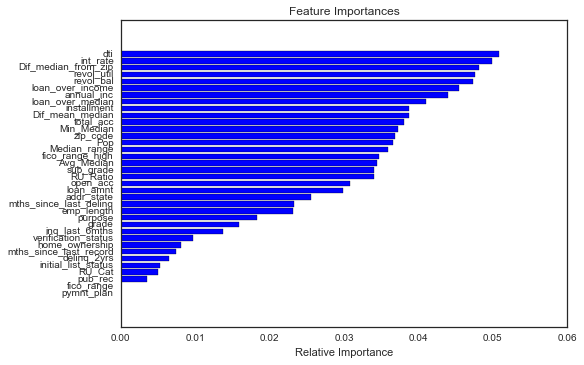

In [92]:
##########################     MODEL 1 - USING BALANACED DATASET    ##########################

y_pred = random_forrest (osdf_rf_train[var], osdf_rf_test[var], osdf_rf_train['target'], osdf_rf_test['target'], n_jobs=-1, n_est=500, w_start=False, zero_weight=1)

Predicted  0.0    1.0    All
True                        
0.0         27   6116   6143
1.0         56  45656  45712
All         83  51772  51855
The MODELED accuracy score of the test/valdiation set is 88.1%
The MODELED accuracy on predicted good loans of test/valid. set is 88.187% with 0.160% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.059%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


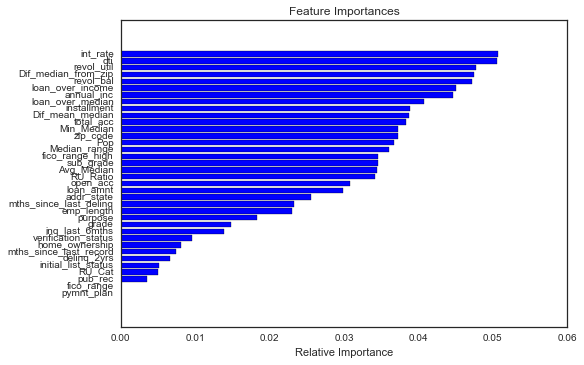

In [93]:
y_pred = random_forrest (osdf_rf_train[var], df_rf_test[var], osdf_rf_train['target'], df_rf_test['target'], n_jobs=-1, n_est=500, w_start=True, zero_weight=1)

Predicted  0.0    1.0    All
True                        
0.0          0   6143   6143
1.0          2  45710  45712
All          2  51853  51855
The MODELED accuracy score of the test/valdiation set is 88.1%
The MODELED accuracy on predicted good loans of test/valid. set is 88.153% with 0.004% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.078%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


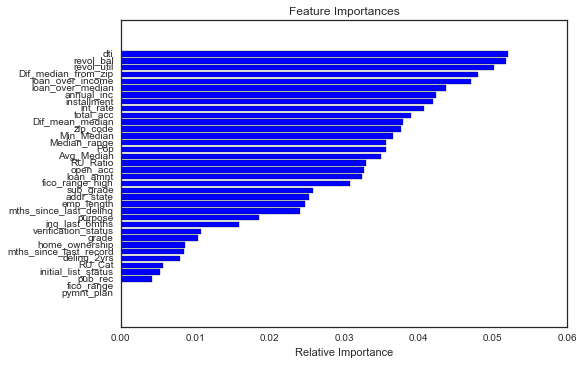

In [94]:
##########################  MODEL 2 - USING ORIGINAL BALANCED DATA  ##########################

y_pred = random_forrest (df_rf_train[var], df_rf_test[var], df_rf_train['target'], df_rf_test['target'], n_jobs=-1, n_est=500, w_start=False, zero_weight=1)

Zero_weight is 2
Predicted    1.0    All
True                   
0.0         6143   6143
1.0        45712  45712
All        51855  51855
The MODELED accuracy score of the test/valdiation set is 88.2%
The MODELED accuracy on predicted good loans of test/valid. set is 88.154% with 0.000% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.079%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


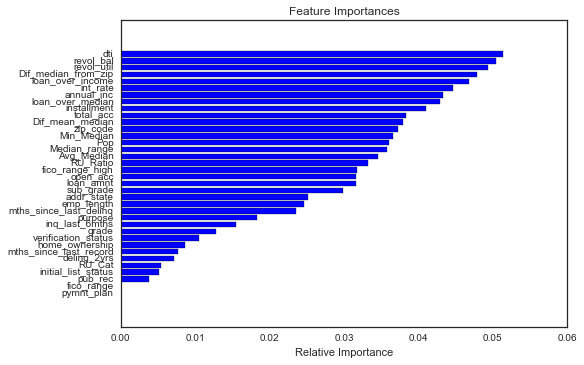



Zero_weight is 4
Predicted  0.0    1.0    All
True                        
0.0          0   6143   6143
1.0          2  45710  45712
All          2  51853  51855
The MODELED accuracy score of the test/valdiation set is 88.1%
The MODELED accuracy on predicted good loans of test/valid. set is 88.153% with 0.004% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.078%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


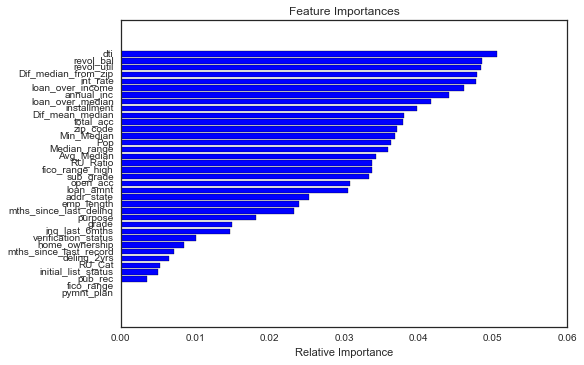



Zero_weight is 6
Predicted  0.0    1.0    All
True                        
0.0          0   6143   6143
1.0          1  45711  45712
All          1  51854  51855
The MODELED accuracy score of the test/valdiation set is 88.2%
The MODELED accuracy on predicted good loans of test/valid. set is 88.153% with 0.002% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.078%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


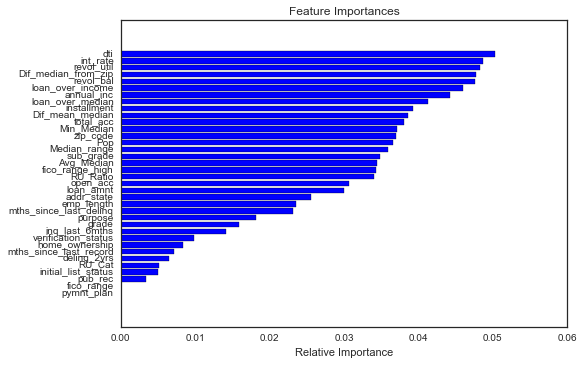



Zero_weight is 8
Predicted  0.0    1.0    All
True                        
0.0          0   6143   6143
1.0          1  45711  45712
All          1  51854  51855
The MODELED accuracy score of the test/valdiation set is 88.2%
The MODELED accuracy on predicted good loans of test/valid. set is 88.153% with 0.002% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.078%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


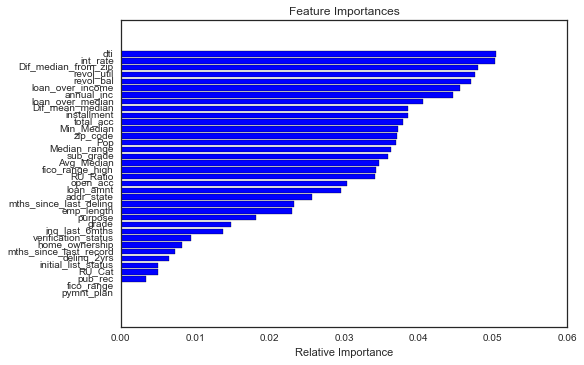



Zero_weight is 10
Predicted  0.0    1.0    All
True                        
0.0          0   6143   6143
1.0          2  45710  45712
All          2  51853  51855
The MODELED accuracy score of the test/valdiation set is 88.1%
The MODELED accuracy on predicted good loans of test/valid. set is 88.153% with 0.004% reduced coverage
The ACTUAL accuracy score of the test/validation set is 88.2%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 11.078%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 11.079%


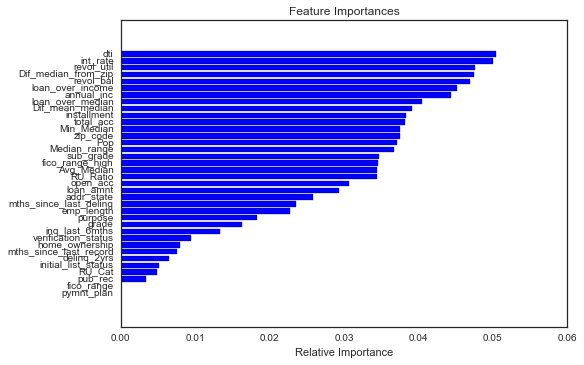

In [95]:
##########################       MODEL 3 - USING CLASS WEIGHT       ##########################
for i in range(2,12,2):
    print ('Zero_weight is {}'.format(i))
    y_pred = random_forrest (df_rf_train[var], df_rf_test[var], df_rf_train['target'], df_rf_test['target'], \
                             n_jobs=-1, n_est=500, w_start=False, zero_weight=i)

Predicted  0.0   1.0   All
True                      
0.0         11   379   390
1.0         29  1321  1350
All         40  1700  1740
The MODELED accuracy score of the test/valdiation set is 76.6%
The MODELED accuracy on predicted good loans of test/valid. set is 77.706% with 2.299% reduced coverage
The ACTUAL accuracy score of the test/validation set is 77.6%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 15.862%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 16.223%


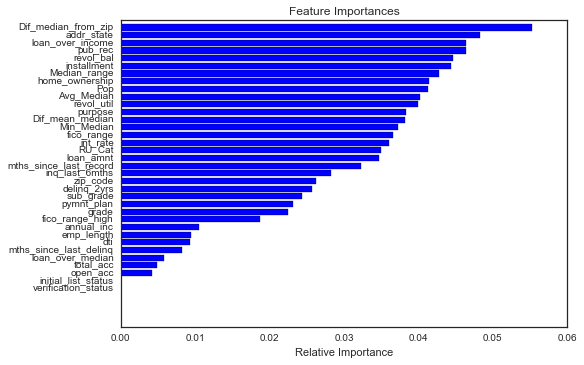

In [109]:
##########################   MODEL 4 - USING ONLY GRADE 'E','F','G' ##########################
dfEFG_rf = df_rf[df_rf['grade'].isin([4,5,6])].copy()
dfEFG_rf.drop('grade', axis=1, inplace=True)

var2 = ['loan_amnt', 'int_rate', 'installment', 'sub_grade',
        'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
        'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
        'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq',
        'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal','revol_util', 
        'total_acc', 'initial_list_status', 'fico_range', 'Avg_Median', 'Min_Median', 
        'Pop', 'Dif_mean_median', 'Median_range','Dif_median_from_zip', 'loan_over_income', 
        'loan_over_median', 'RU_Cat', 'RU_Ratio']

### SPLITTING DATA INTO TRAINING AND TESTING SETS
np.random.seed(2016)
msk = np.random.rand(len(dfEFG_rf)) < 0.70
dfEFG_rf_train = dfEFG_rf[msk]
dfEFG_rf_test = dfEFG_rf[~msk]

## Factorized the target, note that sort must be equal True to rain 1 and 0 integrity
y_EFG_train, _ = pd.factorize(dfEFG_rf_train['target'], sort=True)
y_EFG_test, _ = pd.factorize(dfEFG_rf_test['target'], sort=True)

## Converting df_rf dataframe into predictor arrays
X_EFG_train = dfEFG_rf_train.values
X_EFG_test = dfEFG_rf_test.values

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_EFG_train==1) / np.count_nonzero(y_EFG_train==0)
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_EFG_train, osy_EFG_train = OS.fit_transform(X_EFG_train, y_EFG_train)
osX_EFG_test, osy_EFG_test = OS.fit_transform(X_EFG_test, y_EFG_test)

## Converting array back to dataframe.
columns = dfEFG_rf.columns
osdf_EFG_rf_train = pd.DataFrame(data=osX_EFG_train, columns=columns)
osdf_EFG_rf_test = pd.DataFrame(data=osX_EFG_test, columns=columns)

y_pred = random_forrest (osdf_EFG_rf_train[var2], dfEFG_rf_test[var2], \
                         osdf_EFG_rf_train['target'], dfEFG_rf_test['target'], \
                         n_jobs=-1, n_est=500, w_start=True, zero_weight=1)

Predicted  0.0   1.0   All
True                      
0.0          0   390   390
1.0          1  1349  1350
All          1  1739  1740
The MODELED accuracy score of the test/valdiation set is 77.5%
The MODELED accuracy on predicted good loans of test/valid. set is 77.573% with 0.057% reduced coverage
The ACTUAL accuracy score of the test/validation set is 77.6%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 16.210%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 16.223%


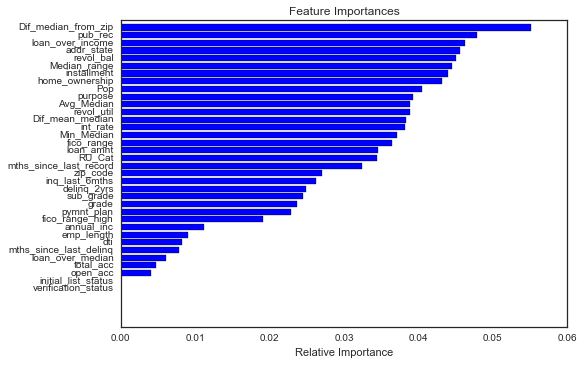

In [110]:
y_pred = random_forrest (dfEFG_rf_train[var2], dfEFG_rf_test[var2], \
                         dfEFG_rf_train['target'], dfEFG_rf_test['target'], \
                         n_jobs=-1, n_est=500, w_start=False, zero_weight=2)

Predicted  0.0   1.0   All
True                      
0.0         23  1365  1388
1.0         24  5448  5472
All         47  6813  6860
The MODELED accuracy score of the test/valdiation set is 79.8%
The MODELED accuracy on predicted good loans of test/valid. set is 79.965% with 0.685% reduced coverage
The ACTUAL accuracy score of the test/validation set is 79.8%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 14.379%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 14.443%


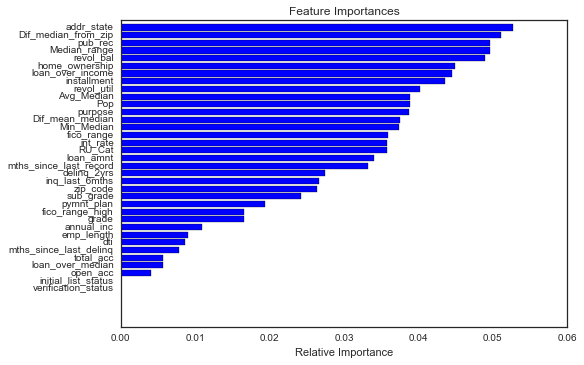

In [111]:
##########################       MODEL 4 - USING ONLY GRADE 'D'     ##########################
dfD_rf = df_rf[df_rf['grade'] == 3 ].copy()
dfD_rf.drop('grade', axis=1, inplace=True)

### SPLITTING DATA INTO TRAINING AND TESTING SETS
np.random.seed(2016)
msk = np.random.rand(len(dfD_rf)) < 0.70
dfD_rf_train = dfD_rf[msk]
dfD_rf_test = dfD_rf[~msk]

## Factorized the target, note that sort must be equal True to rain 1 and 0 integrity
y_D_train, _ = pd.factorize(dfD_rf_train['target'], sort=True)
y_D_test, _ = pd.factorize(dfD_rf_test['target'], sort=True)

## Converting df_rf dataframe into predictor arrays
X_D_train = dfD_rf_train.values
X_D_test = dfD_rf_test.values

## Balancing the dataset so that good loans vs bad loans volumns are balanced
t_ratio =  np.count_nonzero(y_D_train==1) / np.count_nonzero(y_D_train==0)
OS = OverSampler(ratio=t_ratio, verbose=verbose)
osX_D_train, osy_D_train = OS.fit_transform(X_D_train, y_D_train)
osX_D_test, osy_D_test = OS.fit_transform(X_D_test, y_D_test)

## Converting array back to dataframe.
columns = dfD_rf.columns
osdf_D_rf_train = pd.DataFrame(data=osX_D_train, columns=columns)
osdf_D_rf_test = pd.DataFrame(data=osX_D_test, columns=columns)

y_pred = random_forrest (osdf_D_rf_train[var2], dfD_rf_test[var2], osdf_D_rf_train['target'], \
                         dfD_rf_test['target'], n_jobs=-1, n_est=500, w_start=True, zero_weight=1)

Predicted  0.0   1.0   All
True                      
0.0          1  1387  1388
1.0          0  5472  5472
All          1  6859  6860
The MODELED accuracy score of the test/valdiation set is 79.8%
The MODELED accuracy on predicted good loans of test/valid. set is 79.778% with 0.015% reduced coverage
The ACTUAL accuracy score of the test/validation set is 79.8%
The PREDICTED Annualized ROI of test/validation set on predicted good loans is: 14.443%
The ACTUAL Annualized ROI of test/validation set on overall true good loans is: 14.443%


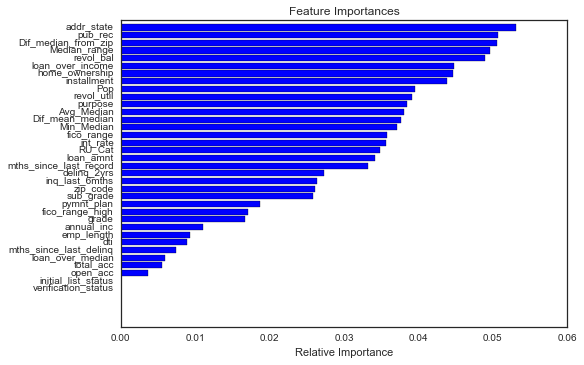

In [112]:
y_pred = random_forrest (dfD_rf_train[var2], dfD_rf_test[var2], dfD_rf_train['target'], \
                         dfD_rf_test['target'], n_jobs=-1, n_est=500, w_start=False, zero_weight=2)